
# Data Preprocessing
In this notebook we load and process the raw data to develop the final dataset for the IBM-Z Datathon. We make use of two main datasets for a list of all observed geoeffective CMEs from the post-SOHO era between 1996-2024, and two data sets for features and targets:

#### Geo-effective CMEs:
- The [Richardson and Cane list](https://izw1.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm); a list of near-Earth CMEs from 1996-2024.
- The [George Mason University CME/ICME list](http://solar.gmu.edu/heliophysics/index.php/GMU_CME/ICME_List); a list of geoeffective CMEs from 2007-2017.

#### Features and Targets:
- The [SOHO-LASCO CME Catalogue](https://cdaw.gsfc.nasa.gov/CME_list/); a list of all CMEs observed from 1996-2024 containing information on physical quantities.
- [OMNIWeb Plus data](https://omniweb.gsfc.nasa.gov/); a list of features associated with the solar wind and sunspot numbers.


## Cleaning the data:

In [1]:
# Importing libraries:
# For data manipulation
import pandas as pd

#For data visualisation:
import matplotlib.pyplot as plt
#from statsmodels.formula.api import mixedlm


#### SOHO-LASCO Catalogue

We begin by loading in the SOHO-LASCO Catalogue to obtain the physical quantities for all CMEs. The original dataset had 11 total features. Most of the data was missing for the mass and kinetic energy hence these have been excluded. We have also excluded the second-order speeds as these are correlated with the linear speed. As a result this dataset contains the dates and times for each CME, together with five features:
- Central Position Angle in degrees.
- Angular Width in degrees.
- Linear Speed in km/s.
- Acceleration in km/s$^2$.
- Measurement Position Angle in degrees.


In [2]:
# Adding filepaths as variables
cane_file_path = r"data/Raw Data/RichardsonCane.csv"
gmu_file_path = r"data/Raw Data/GMU.csv"
soho_file_path = r"data/Raw Data/SOHO_LASCO.csv"
omniweb_file_path = r"data/Raw Data/OMNIWeb.csv"

In [3]:
# Reading SOHO-LASCO dataset
soho_df = pd.read_csv(soho_file_path)
soho_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39285 entries, 0 to 39284
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          39285 non-null  object 
 1   Time          39285 non-null  object 
 2   CentralPA     39285 non-null  object 
 3   AngularWidth  39285 non-null  int64  
 4   LinearSpeed   39166 non-null  float64
 5   Accel         39285 non-null  object 
 6   MPA           39285 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.1+ MB


In [4]:
soho_df.head(200)

,Date,Time,CentralPA,AngularWidth,LinearSpeed,Accel,MPA
0,11/01/1996,00:14:36,267,18,499.0,-64.3*,272
1,13/01/1996,22:08:30,265,16,290.0,2.8*,266
2,15/01/1996,07:01:10,262,43,525.0,-31.1,272
3,22/01/1996,03:11:01,105,37,267.0,-126.3*,103
4,26/01/1996,09:16:19,90,27,262.0,1.9*,90
...,...,...,...,...,...,...,...
195,20/06/1996,13:53:43,73,16,220.0,0.8*,82
196,20/06/1996,17:49:03,105,38,80.0,6.6*,103
197,20/06/1996,19:18:00,1,6,91.0,-4.3*,360
198,21/06/1996,02:07:30,260,20,154.0,2.2*,265


After inspecting the dataset, we will do the following:
- Convert all missing values labelled as "------" and "NaN" to `None`.
- Convert Central PA values labelled as "Halo" to 360.
- Reformat the Acceleration column by removing asterisks.
- Convert all columns to numeric.
- Remove CME data corresponding to an angular width below 90 degrees as it is known that these are not likely to be geoeffective.
- Replace labelled columns "Date" and "Time" with a single "Datetime" column.

In [5]:
# Step 1: Replace all missing values ('------' and 'NaN') with None
soho_df.replace(['------', 'NaN'], None, inplace=True)

# Step 2: Convert Angular Width values labelled as "Halo" to 360
soho_df['CentralPA'] = soho_df['CentralPA'].replace('Halo', 360)

# Step 3: Remove asterisks from the Acceleration column
soho_df['Accel'] = soho_df['Accel'].astype(str).str.replace('*', '', regex=False)

# Step 4: Convert all columns to numeric, except the first two (Date and Time)
cols_to_convert = soho_df.columns[2:]  # Keep first two columns (Date and Time) as object
soho_df[cols_to_convert] = soho_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Step 5: Remove rows where Central PA is below 90 degrees
soho_df = soho_df[soho_df['AngularWidth'] >= 90]

# Step 6: Combine first two columns
soho_df['Datetime'] = pd.to_datetime(soho_df['Date'] + ' ' + soho_df['Time'], dayfirst=True) # Creating Datetime column
soho_df = soho_df.drop(soho_df.columns[[0, 1]], axis=1) # Drop the first two columns by index
last_column = soho_df.pop(soho_df.columns[-1])  # Pop the last column
soho_df.insert(0, last_column.name, last_column)  # Insert it at the front

soho_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5873 entries, 12 to 39282
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      5873 non-null   datetime64[ns]
 1   CentralPA     5873 non-null   int64         
 2   AngularWidth  5873 non-null   int64         
 3   LinearSpeed   5867 non-null   float64       
 4   Accel         5851 non-null   float64       
 5   MPA           5873 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 321.2 KB


In [6]:
soho_df.head(200) 

,Datetime,CentralPA,AngularWidth,LinearSpeed,Accel,MPA
12,1996-02-02 23:00:47,180,119,80.0,1.8,164
83,1996-04-29 14:38:48,360,360,65.0,NaN,149
85,1996-05-01 08:41:46,94,95,314.0,0.7,70
188,1996-06-18 17:28:50,84,95,64.0,-0.4,79
285,1996-07-20 09:28:16,31,175,246.0,9.4,34
...,...,...,...,...,...,...
2561,1998-11-07 20:54:05,321,96,750.0,23.7,314
2565,1998-11-08 11:54:05,264,196,559.0,6.2,214
2569,1998-11-09 01:54:05,16,94,144.0,0.7,27
2573,1998-11-09 18:17:55,330,190,325.0,2.6,338


#### OMNIWeb Plus Dataset
To obtain the final list of features, we must concatenate the SOHO-LASCO Catalogue with the OMNIWeb Plus Dataset. This dataset contains 12 features associated with the solar wind:

- The X-component of the magnetic field in nT.
- The Y-component of the magnetic field in nT.
- The Z-component of the magnetic field in nT.
- Plasma Temperature in Kelvin.
- Solar Proton Density n/cc.
- Flow Speed in km/s.
- Longitude Angle in degrees.
- Latitude Angle in degrees.
- Proton Density Ratio (unitless).
- Flow Pressure in nPa.
- Plasma Beta (unitless).
- Sunspot Number.

In [7]:
# Loading in OMNIWeb Plus data
omniweb_df = pd.read_csv(omniweb_file_path)
omniweb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261168 entries, 0 to 261167
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Datetime           261168 non-null  object 
 1   BX                 261168 non-null  float64
 2   BY                 261168 non-null  float64
 3   BZ                 261168 non-null  float64
 4   Plasma_Temp        261168 non-null  int64  
 5   Proton_Density     261168 non-null  float64
 6   Plasma_Speed       261168 non-null  int64  
 7   Plasma_Long_Angle  261168 non-null  float64
 8   Plasma_Lat_Angle   261168 non-null  float64
 9   Alpha_Prot_Ratio   261168 non-null  float64
 10  Flow_Pressure      261168 non-null  float64
 11  Plasma_Beta        261168 non-null  float64
 12  Sunspot_No         261168 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 25.9+ MB


In [8]:
omniweb_df.head()

,Datetime,BX,BY,BZ,Plasma_Temp,Proton_Density,Plasma_Speed,Plasma_Long_Angle,Plasma_Lat_Angle,Alpha_Prot_Ratio,Flow_Pressure,Plasma_Beta,Sunspot_No
0,01/01/1995 00:00,-0.6,3.2,-2.1,15816,16.3,315,-0.4,4.6,0.016,2.87,6.11,13
1,01/01/1995 01:00,-0.9,2.4,-1.3,15601,18.8,315,-0.1,3.1,0.013,3.28,12.51,13
2,01/01/1995 02:00,0.5,1.8,-0.4,20703,19.3,320,0.3,2.1,0.012,3.46,11.69,13
3,01/01/1995 03:00,-3.2,2.5,0.3,25094,16.4,317,1.6,2.2,0.013,2.90,5.66,13
4,01/01/1995 04:00,-4.3,2.1,0.3,25604,14.5,313,1.7,2.2,0.015,2.51,4.03,13


After taking a look at the OMNIWeb Plus Data, we next to the following to the dataset:
- Reformat first column to match the SOHO-LASCO data.
- Match times by averaging the 6-hour window after CME ejection.
- Concatenate both datasets to obtain final list of all 17 features.

In [9]:
# Step 1: Reformat Datetime column
omniweb_df['Datetime'] = pd.to_datetime(omniweb_df['Datetime'] + ':00', dayfirst=True)
omniweb_df.head(500)

,Datetime,BX,BY,BZ,Plasma_Temp,Proton_Density,Plasma_Speed,Plasma_Long_Angle,Plasma_Lat_Angle,Alpha_Prot_Ratio,Flow_Pressure,Plasma_Beta,Sunspot_No
0,1995-01-01 00:00:00,-0.6,3.2,-2.1,15816,16.3,315,-0.4,4.6,0.016,2.87,6.11,13
1,1995-01-01 01:00:00,-0.9,2.4,-1.3,15601,18.8,315,-0.1,3.1,0.013,3.28,12.51,13
2,1995-01-01 02:00:00,0.5,1.8,-0.4,20703,19.3,320,0.3,2.1,0.012,3.46,11.69,13
3,1995-01-01 03:00:00,-3.2,2.5,0.3,25094,16.4,317,1.6,2.2,0.013,2.90,5.66,13
4,1995-01-01 04:00:00,-4.3,2.1,0.3,25604,14.5,313,1.7,2.2,0.015,2.51,4.03,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1995-01-21 15:00:00,-3.6,1.2,-3.2,20014,11.3,348,-1.0,-0.3,0.025,2.51,2.68,74
496,1995-01-21 16:00:00,-3.1,2.6,1.2,31369,10.3,352,-1.0,-1.8,0.030,2.39,2.85,74
497,1995-01-21 17:00:00,-3.7,3.3,3.4,42588,10.5,356,-1.5,-2.3,0.039,2.57,1.77,74
498,1995-01-21 18:00:00,-3.7,4.2,0.7,46710,15.2,364,-3.2,-1.0,0.037,3.86,1.97,74


In [10]:
omniweb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261168 entries, 0 to 261167
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Datetime           261168 non-null  datetime64[ns]
 1   BX                 261168 non-null  float64       
 2   BY                 261168 non-null  float64       
 3   BZ                 261168 non-null  float64       
 4   Plasma_Temp        261168 non-null  int64         
 5   Proton_Density     261168 non-null  float64       
 6   Plasma_Speed       261168 non-null  int64         
 7   Plasma_Long_Angle  261168 non-null  float64       
 8   Plasma_Lat_Angle   261168 non-null  float64       
 9   Alpha_Prot_Ratio   261168 non-null  float64       
 10  Flow_Pressure      261168 non-null  float64       
 11  Plasma_Beta        261168 non-null  float64       
 12  Sunspot_No         261168 non-null  int64         
dtypes: datetime64[ns](1), float64(9), int64(3)
m

In [11]:
replace_values = [9999, 99, 999, 999.9, 9999999., 9999., 99.99, 9.999, 999.99, 999]
omniweb_df.replace(replace_values, None, inplace=True)

In [12]:
# Define a function to get the 6-hour averaged data after each CME
def get_solar_wind_average(cme_time, omniweb_data, window_hours=6):
    # Get the end time for the 6-hour window
    end_time = cme_time + pd.Timedelta(hours=window_hours)
    
    # Filter OMNIWeb data for the 6-hour window
    filtered_omniweb = omniweb_data[(omniweb_data['Datetime'] >= cme_time) & (omniweb_data['Datetime'] <= end_time)]
    
    # Calculate the average of all numerical columns in this window
    return filtered_omniweb.mean()

# Apply this function to each CME in the Cane dataset
averaged_solar_wind = soho_df['Datetime'].apply(get_solar_wind_average, omniweb_data=omniweb_df)

# Combine the averaged solar wind features with the original Cane dataset
combined_df = pd.concat([soho_df, averaged_solar_wind], axis=1)
combined_df.columns.values[6] = 'Datetime_2' # Renaming duplicated column

features_df  = combined_df.drop('Datetime_2', axis=1) # Removing duplicated Datetime column
features_df.head(200)


,Datetime,CentralPA,AngularWidth,LinearSpeed,Accel,MPA,BX,BY,BZ,Plasma_Temp,Proton_Density,Plasma_Speed,Plasma_Long_Angle,Plasma_Lat_Angle,Alpha_Prot_Ratio,Flow_Pressure,Plasma_Beta,Sunspot_No
12,1996-02-02 23:00:47,180,119,80.0,1.8,164,4.150000,-0.116667,3.333333e-02,75709.500000,3.466667,493.666667,1.466667,-1.000000,0.016667,1.506667,1.785000,12.000000
83,1996-04-29 14:38:48,360,360,65.0,NaN,149,-0.583333,0.300000,7.833333e-01,25115.666667,11.800000,366.500000,-0.083333,-0.066667,0.012500,2.780000,20.178333,0.000000
85,1996-05-01 08:41:46,94,95,314.0,0.7,70,3.083333,-0.366667,-1.850372e-17,49811.000000,6.900000,406.166667,2.850000,-1.916667,0.028667,2.116667,4.000000,0.000000
188,1996-06-18 17:28:50,84,95,64.0,-0.4,79,0.933333,-4.950000,-1.900000e+00,60472.500000,9.083333,388.000000,-1.900000,-2.700000,0.031667,2.596667,2.695000,14.000000
285,1996-07-20 09:28:16,31,175,246.0,9.4,34,0.533333,3.500000,-1.283333e+00,102147.166667,7.866667,422.500000,1.100000,-1.450000,0.019000,2.518333,3.020000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561,1998-11-07 20:54:05,321,96,750.0,23.7,314,4.466667,10.183333,-5.783333e+00,36940.333333,7.083333,471.833333,-1.200000,-1.633333,0.022167,2.940000,0.351667,128.000000
2565,1998-11-08 11:54:05,264,196,559.0,6.2,214,-6.150000,-8.816667,2.028333e+01,111616.833333,18.650000,540.500000,2.600000,-1.933333,0.081167,11.976667,0.283333,121.000000
2569,1998-11-09 01:54:05,16,94,144.0,0.7,27,6.916667,12.350000,-5.350000e+00,32074.833333,8.333333,484.666667,-2.716667,3.200000,0.068667,4.171667,0.173333,93.000000
2573,1998-11-09 18:17:55,330,190,325.0,2.6,338,1.383333,-8.666667,-6.666667e+00,14778.500000,3.283333,422.166667,-0.916667,3.683333,0.072400,1.256667,0.128333,92.333333


In [13]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5873 entries, 12 to 39282
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Datetime           5873 non-null   datetime64[ns]
 1   CentralPA          5873 non-null   int64         
 2   AngularWidth       5873 non-null   int64         
 3   LinearSpeed        5867 non-null   float64       
 4   Accel              5851 non-null   float64       
 5   MPA                5873 non-null   int64         
 6   BX                 5786 non-null   float64       
 7   BY                 5786 non-null   float64       
 8   BZ                 5786 non-null   float64       
 9   Plasma_Temp        5738 non-null   float64       
 10  Proton_Density     5725 non-null   float64       
 11  Plasma_Speed       5843 non-null   float64       
 12  Plasma_Long_Angle  5843 non-null   float64       
 13  Plasma_Lat_Angle   5843 non-null   float64       
 14  Alpha_Prot_

In [14]:
features_df.to_csv(r'data/features.csv', index=False)

#### Target Geoeffective CMEs and Transit Times


In [15]:
cane_df = pd.read_csv(cane_file_path)
cane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LASCO CME Y/M/D (UT)    558 non-null    object
 1   Disturbance Y/M/D (UT)  558 non-null    object
 2   Dst (nT)                558 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 13.2+ KB


In [16]:
cane_df.head(100)

,LASCO CME Y/M/D (UT),Disturbance Y/M/D (UT),Dst (nT)
0,1996/05/27 1500,1996/05/27 1500,-33
1,1996/07/01 1800,1996/07/01 1320,-20
2,1996/08/07 1200,1996/08/07 0600,-23
3,1996/12/19 1630,1996/12/23 1600,-18
4,1997/01/06 1510,1997/01/10 0104,-78
...,...,...,...
95,2000/01/18 1754,2000/01/22 0023,-97
96,2000/02/08 0930,2000/02/11 0258,-25
97,2000/02/10 0230,2000/02/11 2352,-133
98,2000/02/12 0431,2000/02/14 0731,-67


In [17]:
cane_df['LASCO CME Y/M/D (UT)'] = pd.to_datetime(cane_df['LASCO CME Y/M/D (UT)'], format='mixed')
cane_df['Disturbance Y/M/D (UT)'] = pd.to_datetime(cane_df['Disturbance Y/M/D (UT)'], format='mixed')
cane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   LASCO CME Y/M/D (UT)    558 non-null    datetime64[ns]
 1   Disturbance Y/M/D (UT)  558 non-null    datetime64[ns]
 2   Dst (nT)                558 non-null    int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 13.2 KB


In [18]:
cane_df.head()

,LASCO CME Y/M/D (UT),Disturbance Y/M/D (UT),Dst (nT)
0,1996-05-27 15:00:00,1996-05-27 15:00:00,-33
1,1996-07-01 18:00:00,1996-07-01 13:20:00,-20
2,1996-08-07 12:00:00,1996-08-07 06:00:00,-23
3,1996-12-19 16:30:00,1996-12-23 16:00:00,-18
4,1997-01-06 15:10:00,1997-01-10 01:04:00,-78


In [19]:
cane_df = cane_df[cane_df['Dst (nT)'] <= -30]

In [20]:
cane_df.head(500)

,LASCO CME Y/M/D (UT),Disturbance Y/M/D (UT),Dst (nT)
0,1996-05-27 15:00:00,1996-05-27 15:00:00,-33
4,1997-01-06 15:10:00,1997-01-10 01:04:00,-78
5,1997-02-07 00:30:00,1997-02-09 13:21:00,-68
6,1997-04-07 14:27:00,1997-04-10 17:45:00,-82
7,1997-04-21 10:00:00,1997-04-21 06:00:00,-107
...,...,...,...
552,2023-09-29 10:00:00,2023-09-28 21:31:00,-47
554,2023-11-09 12:23:00,2023-11-12 06:13:00,-42
555,2023-11-28 20:24:00,2023-12-01 09:26:00,-107
556,2023-12-12 00:00:00,2023-12-15 11:48:00,-33


In [21]:
cane_df['TransitTime'] = cane_df['Disturbance Y/M/D (UT)'] - cane_df['LASCO CME Y/M/D (UT)']

In [22]:
cane_df.head()

,LASCO CME Y/M/D (UT),Disturbance Y/M/D (UT),Dst (nT),TransitTime
0,1996-05-27 15:00:00,1996-05-27 15:00:00,-33,0 days 00:00:00
4,1997-01-06 15:10:00,1997-01-10 01:04:00,-78,3 days 09:54:00
5,1997-02-07 00:30:00,1997-02-09 13:21:00,-68,2 days 12:51:00
6,1997-04-07 14:27:00,1997-04-10 17:45:00,-82,3 days 03:18:00
7,1997-04-21 10:00:00,1997-04-21 06:00:00,-107,-1 days +20:00:00


In [23]:
cane_df = cane_df[cane_df['TransitTime'].dt.total_seconds() > 0]
cane_df['TransitTime'] = cane_df['TransitTime'].dt.total_seconds() / 3600

In [24]:
cane_df['Geoeffective'] = 1
cane_df = cane_df.drop(cane_df.columns[[1, 2]], axis=1)
cane_df.head()

,LASCO CME Y/M/D (UT),TransitTime,Geoeffective
4,1997-01-06 15:10:00,81.900000,1
5,1997-02-07 00:30:00,60.850000,1
6,1997-04-07 14:27:00,75.300000,1
8,1997-05-12 05:30:00,68.483333,1
9,1997-05-21 21:00:00,108.950000,1


In [25]:
cane_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, 4 to 557
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   LASCO CME Y/M/D (UT)  238 non-null    datetime64[ns]
 1   TransitTime           238 non-null    float64       
 2   Geoeffective          238 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 7.4 KB


In [26]:
gmu_df = pd.read_csv(gmu_file_path)

In [27]:
gmu_df.head()


,CME in LASCO,Transit time,Geoeffective
0,11/16/2007 08:50:00,87:10:00,1
1,12/12/2008 09:06:00,112:54:00,1
2,01/21/2009 21:08:00,103:52:00,1
3,01/31/2009 01:54:00,89:06:00,1
4,09/25/2009 08:06:00,117:54:00,1


In [28]:
gmu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CME in LASCO  72 non-null     object
 1   Transit time  72 non-null     object
 2   Geoeffective  72 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ KB


In [29]:

gmu_df['Transit time'] = pd.to_timedelta(gmu_df['Transit time'])
gmu_df['Transit time'] = gmu_df['Transit time'].dt.total_seconds() / 3600

In [30]:
gmu_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CME in LASCO  72 non-null     object 
 1   Transit time  72 non-null     float64
 2   Geoeffective  72 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ KB


In [31]:
gmu_df.head(100)

,CME in LASCO,Transit time,Geoeffective
0,11/16/2007 08:50:00,87.166667,1
1,12/12/2008 09:06:00,112.900000,1
2,01/21/2009 21:08:00,103.866667,1
3,01/31/2009 01:54:00,89.100000,1
4,09/25/2009 08:06:00,117.900000,1
...,...,...,...
67,11/04/2015 14:48:00,13.350000,1
68,12/28/2015 12:12:05,15.766667,1
69,07/17/2016 12:12:05,46.000000,1
70,10/09/2016 02:36:00,49.600000,1


In [32]:
#save CSV
gmu_df.to_csv(r"data/cleaned_gmu.csv", index=False)

In [33]:
cane_df.to_csv(r"data/cleaned_cane.csv", index=False)

In [34]:
from datetime import timedelta


# Convert the datetime columns to a consistent format for merging
features_df['Datetime'] = pd.to_datetime(features_df['Datetime'])
cane_df['LASCO CME Y/M/D (UT)'] = pd.to_datetime(cane_df['LASCO CME Y/M/D (UT)'])
gmu_df['CME in LASCO'] = pd.to_datetime(gmu_df['CME in LASCO'])

# Rename columns for consistency
cane_df.rename(columns={'LASCO CME Y/M/D (UT)': 'Datetime'}, inplace=True)
gmu_df.rename(columns={'CME in LASCO': 'Datetime'}, inplace=True)

# Merge the cleaned_cane and cleaned_gmu datasets together
geoeffective_df = pd.concat([cane_df, gmu_df])

# Remove duplicate CMEs from the combined geoeffective dataframe based on the datetime
geoeffective_df = geoeffective_df.drop_duplicates(subset='Datetime')

# Set an epsilon time window (e.g., +/- 6 hours)
epsilon = timedelta(hours=0.5)

# Create new columns for Geoeffective and TransitTime with default values
merged_df = features_df.copy()
merged_df['Geoeffective'] = 0
merged_df['TransitTime'] = None

# Iterate over each geoeffective event and match with the features within the epsilon window
for _, row in geoeffective_df.iterrows():
    cme_datetime = row['Datetime']
    
    # Find matches within the epsilon window
    mask = (merged_df['Datetime'] >= cme_datetime - epsilon) & (merged_df['Datetime'] <= cme_datetime + epsilon)
    merged_df.loc[mask, 'Geoeffective'] = 1
    merged_df.loc[mask, 'TransitTime'] = row['TransitTime']

# Optionally, display the first few rows of the updated merged dataframe
merged_df.head()

,Datetime,CentralPA,AngularWidth,LinearSpeed,Accel,MPA,BX,BY,BZ,Plasma_Temp,Proton_Density,Plasma_Speed,Plasma_Long_Angle,Plasma_Lat_Angle,Alpha_Prot_Ratio,Flow_Pressure,Plasma_Beta,Sunspot_No,Geoeffective,TransitTime
12,1996-02-02 23:00:47,180,119,80.0,1.8,164,4.150000,-0.116667,3.333333e-02,75709.500000,3.466667,493.666667,1.466667,-1.000000,0.016667,1.506667,1.785000,12.0,0,None
83,1996-04-29 14:38:48,360,360,65.0,NaN,149,-0.583333,0.300000,7.833333e-01,25115.666667,11.800000,366.500000,-0.083333,-0.066667,0.012500,2.780000,20.178333,0.0,0,None
85,1996-05-01 08:41:46,94,95,314.0,0.7,70,3.083333,-0.366667,-1.850372e-17,49811.000000,6.900000,406.166667,2.850000,-1.916667,0.028667,2.116667,4.000000,0.0,0,None
188,1996-06-18 17:28:50,84,95,64.0,-0.4,79,0.933333,-4.950000,-1.900000e+00,60472.500000,9.083333,388.000000,-1.900000,-2.700000,0.031667,2.596667,2.695000,14.0,0,None
285,1996-07-20 09:28:16,31,175,246.0,9.4,34,0.533333,3.500000,-1.283333e+00,102147.166667,7.866667,422.500000,1.100000,-1.450000,0.019000,2.518333,3.020000,0.0,0,None


In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5873 entries, 12 to 39282
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Datetime           5873 non-null   datetime64[ns]
 1   CentralPA          5873 non-null   int64         
 2   AngularWidth       5873 non-null   int64         
 3   LinearSpeed        5867 non-null   float64       
 4   Accel              5851 non-null   float64       
 5   MPA                5873 non-null   int64         
 6   BX                 5786 non-null   float64       
 7   BY                 5786 non-null   float64       
 8   BZ                 5786 non-null   float64       
 9   Plasma_Temp        5738 non-null   float64       
 10  Proton_Density     5725 non-null   float64       
 11  Plasma_Speed       5843 non-null   float64       
 12  Plasma_Long_Angle  5843 non-null   float64       
 13  Plasma_Lat_Angle   5843 non-null   float64       
 14  Alpha_Prot_

In [36]:
geoeffective_count_merged = merged_df['Geoeffective'].sum()

In [37]:
merged_df.to_csv(r"data/final_dataset.csv", index=False)

In [38]:
from sklearn.impute import KNNImputer

#imputing missing NaN values from dataset due to averaging

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
columns_to_impute = merged_df.select_dtypes(include=['float64', 'int64']).columns
df_imputed = merged_df.copy()
data_imputed = df_imputed[columns_to_impute] = knn_imputer.fit_transform(merged_df[columns_to_impute])
df_imputed.to_csv('data/Imputed_DataFrame.csv', index=False)

#bootstrapping more data to the dataset

additional_data = df_imputed.sample(n=100, replace=True)
df_augmented = pd.concat([df_imputed, additional_data], ignore_index=True)
df_augmented[['Datetime', 'LinearSpeed']].head()
df_augmented.to_csv('data/bootstrapped_augmented_dataset.csv', index=False)

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from sklearn import metrics
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV as rscv

In [40]:
# linear regression - regression

df = pd.read_csv('data/final_dataset.csv')
df = df.drop(['Datetime', 'TransitTime'], axis=1)
df = df.dropna()
targets = df['Geoeffective']
features = df.drop('Geoeffective', axis=1)

# Assume X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=43)

grid={
    "C":np.logspace(-3,3,7), 
    "penalty":["l1","l2"]
    }

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)
logreg = LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=kfold)
logreg_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

y_pred = logreg_cv.best_estimator_.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.9617122473246136
Accuracy: 0.9562737642585551


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [43]:
# SVM - classification 

df = pd.read_csv('data/final_dataset.csv')
df = df.drop(['Datetime', 'TransitTime'], axis=1)
df = df.dropna()
targets = df['Geoeffective']
features = df.drop('Geoeffective', axis=1)

# Assume X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=43)

clf = svm.SVC(kernel='rbf') 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'poly', 'rbf']
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)
grid_search = GridSearchCV(clf, param_grid, scoring=None, cv=kfold, n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and test it
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test_scaled)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(grid_search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 

In [42]:
# SVR - regression
df = pd.read_csv('data/final_dataset.csv')
df = df.drop('Datetime', axis=1)
df = df.dropna()
targets = df['TransitTime']
features = df.drop('TransitTime', axis=1)

# Assume X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=43)

# Define the SVR model and parameters for GridSearch
svr = SVR(kernel='rbf')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}

# Perform grid search with cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=43)
grid_search = GridSearchCV(svr, param_grid, scoring='r2', cv=kfold, n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and test it
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"R^2 Score: {r2}")

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Best Parameters: {'C': 10, 'epsilon': 0.5, 'gamma': 0.01}
R^2 Score: 0.5007192380950563


In [44]:
# For data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# For model building and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
)

# For plotting graphs
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mean Squared Error (MSE): 179.50
Root Mean Squared Error (RMSE): 13.40
Mean Absolute Error (MAE): 11.03
R-squared (R2 Score): 0.59


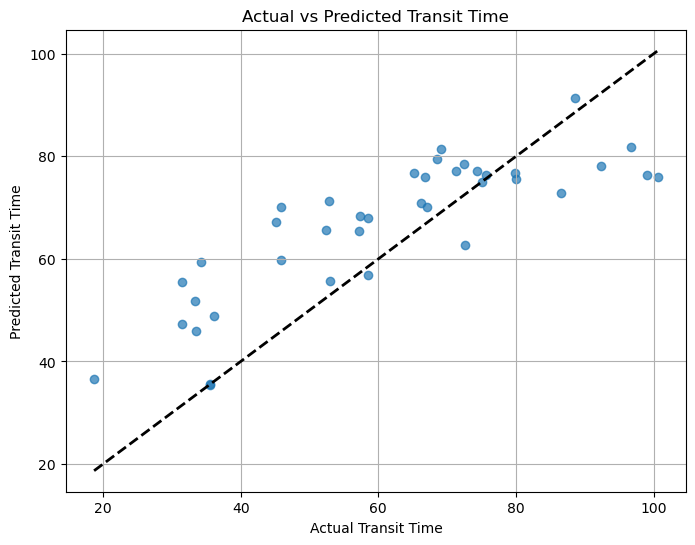

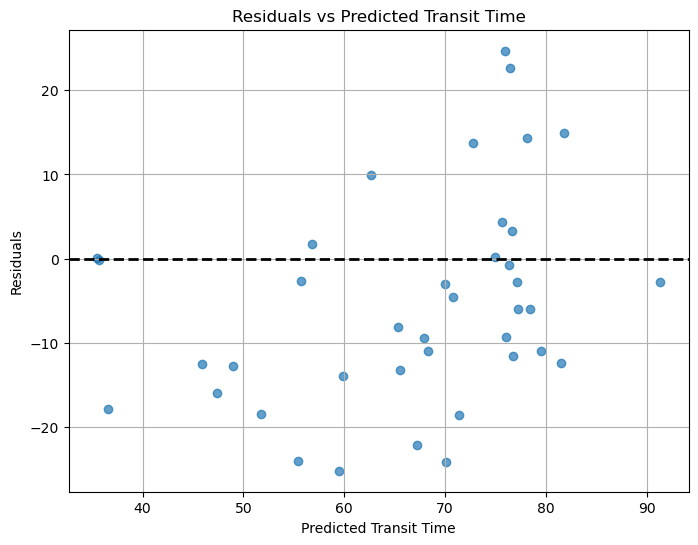

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mean Squared Error (MSE): 268.83
Root Mean Squared Error (RMSE): 16.40
Mean Absolute Error (MAE): 13.21
R-squared (R2 Score): 0.35


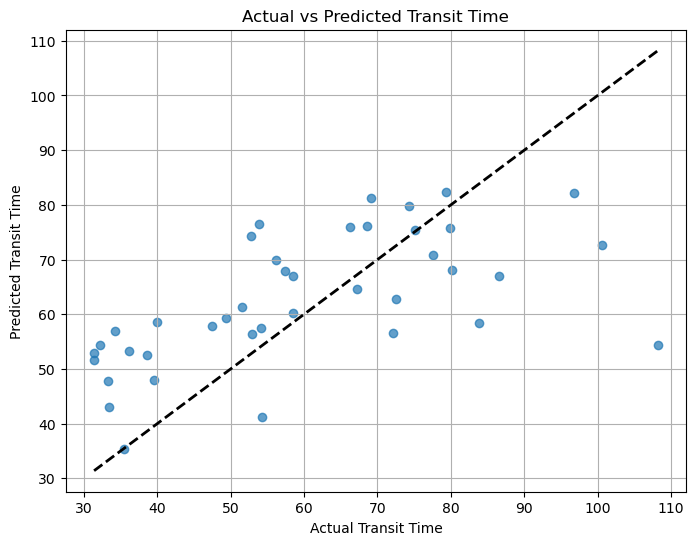

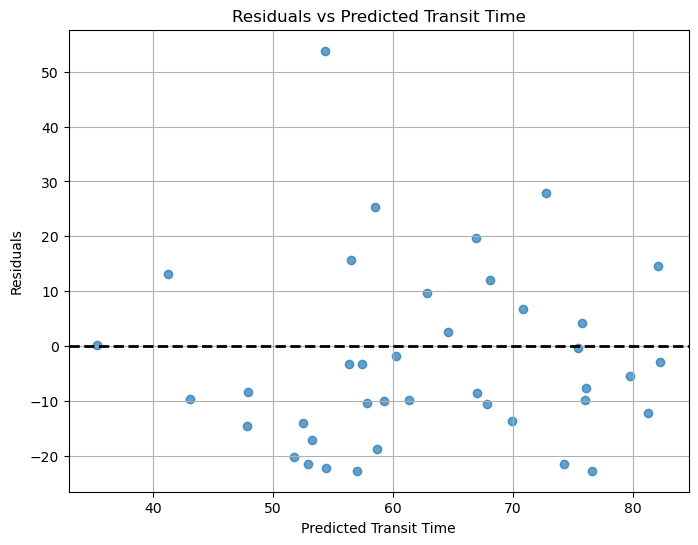

In [45]:
data_file=['data/final_dataset.csv','data/Imputed_DataFrame.csv','data/bootstrapped_augmented_dataset.csv']

# random trees
for n in range(1,3):
    # Load data from CSV file
    data = pd.read_csv(data_file[n])

    # Replace all occurrences of '9.99', '999.9', and '9999999' with NaN
    data.replace([9.99, 999.9, 9999999], np.nan, inplace=True)

    # Drop rows with missing values
    data.dropna(inplace=True)

    # Convert 'Accel' and 'CentralPA' to numeric, handling non-numeric entries
    data['Accel'] = pd.to_numeric(data['Accel'], errors='coerce')
    data['CentralPA'] = pd.to_numeric(data['CentralPA'].replace('Halo', '360'), errors='coerce')

    # Drop any rows with NaN values after conversion
    data.dropna(inplace=True)

    # Separate features (X) and target variable (y)
    X = data.drop(columns=['Datetime', 'TransitTime', 'Geoeffective'])
    y = data['TransitTime']

    # Handle missing values using SimpleImputer (not necessary here since we've dropped NaNs)
    # imputer = SimpleImputer(strategy="mean")
    # X_imputed = imputer.fit_transform(X)

    # Feature scaling using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # =====================================
    # Data Splitting
    # =====================================

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # =====================================
    # Model Training and Hyperparameter Tuning
    # =====================================

    # Define the Random Forest regressor
    rfr = RandomForestRegressor(random_state=42)

    # Define the hyperparameter grid for RandomizedSearchCV
    param_dist = {
        "n_estimators": [100, 200, 500],            # Number of trees
        "max_depth": [None, 10, 20, 30],            # Depth of each tree
        "min_samples_split": [2, 5, 10],            # Minimum samples required to split a node
        "min_samples_leaf": [1, 2, 4],              # Minimum samples required at each leaf node
        "max_features": ["sqrt", "log2"],           # Number of features to consider at each split
        "bootstrap": [True, False],                 # Whether bootstrap samples are used
    }

    # Use KFold cross-validator for regression
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform Randomized Search Cross-Validation to find the best hyperparameters
    random_search = RandomizedSearchCV(
        estimator=rfr,
        param_distributions=param_dist,
        n_iter=20,                   # Reduced number of iterations for efficiency
        scoring="neg_mean_squared_error",  # Use appropriate scoring for regression
        cv=kf,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # Fit the model on the training data
    random_search.fit(X_train, y_train)

    # Retrieve the best model from RandomizedSearchCV
    best_model = random_search.best_estimator_

    # =====================================
    # Model Evaluation
    # =====================================

    # Make predictions on the test data
    y_pred = best_model.predict(X_test)

    # Evaluate the model using regression metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print evaluation metrics
    print("Mean Squared Error (MSE): {:.2f}".format(mse))
    print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
    print("Mean Absolute Error (MAE): {:.2f}".format(mae))
    print("R-squared (R2 Score): {:.2f}".format(r2))

    # =====================================
    # Plotting Predicted vs Actual Values
    # =====================================

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel("Actual Transit Time")
    plt.ylabel("Predicted Transit Time")
    plt.title("Actual vs Predicted Transit Time")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.grid(True)
    plt.show()

    # Plotting Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.xlabel("Predicted Transit Time")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted Transit Time")
    plt.axhline(0, color='k', linestyle='--', lw=2)
    plt.grid(True)
    plt.show()

In [47]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

for n in range(0,3):
    data = pd.read_csv(data_file[n])
    #data['Accel'] = pd.to_numeric(data['Accel'].str.replace('*', '', regex=False), errors='coerce')
    #data['CentralPA'] = pd.to_numeric(data['CentralPA'].str.replace('halo', '360', regex=False), errors='coerce')
    data.dropna(inplace=True)
    data.replace([9.99, 999.9, 9999999], np.nan, inplace=True)
    print(data.head())


    # Features (X) - All columns except the target 'arrival_time'
    X = data.drop(columns=['Datetime','TransitTime', 'Geoeffective'])

    y = data['Geoeffective']
    #80%-20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    param_distributions = {
        'n_estimators': [50, 100, 200, 300],       # Number of boosting rounds
        'max_depth': [3, 4, 5, 6, 7, 8, 9],              # Maximum depth of trees
        'learning_rate': [0.01, 0.05, 0.1],        # Learning rate
        'subsample': [0.6, 0.8, 1.0],              # Subsample ratio for instances
        'colsample_bytree': [0.6, 0.8, 1.0],       # Subsample ratio for features
        'gamma': [0, 0.1, 0.2, 0.3],               # Minimum loss reduction for split
        'reg_alpha': [0, 0.01, 0.1],               # L1 regularization term
        'reg_lambda': [1, 1.5, 2],                 # L2 regularization term
    }
    #setup of model
    xgboost_model = xgb.XGBClassifier(scale_pos_weight=7.95,use_label_encoder=False, eval_metric='logloss')  # logloss is typical for binary classification
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(xgboost_model, X, y, cv=skf, scoring='roc_auc')

    random_search = RandomizedSearchCV(
        estimator=xgboost_model,                # The model to train
        param_distributions=param_distributions, # The hyperparameter space
        n_iter=50,                              # Number of random combinations to try
        scoring='accuracy',        # Scoring metric (MSE for regression)
        cv=3,                                   # 3-fold cross-validation
        verbose=2,                              # Show output during the process
        random_state=42,                        # Reproducibility
        n_jobs=-1                               # Use all available cores
    )
    #     n_estimators=100,    # Number of boosting rounds (trees)
    #     max_depth=6,         # Maximum depth of each tree
    #     learning_rate=0.1,   # Learning rate (controls the contribution of each tree)
    #     subsample=0.8,       # Subsampling ratio of the training data
    #     colsample_bytree=0.8 # Subsampling ratio of the features (columns)
    # )

    random_search.fit(X_train, y_train)

    class_distribution = data['Geoeffective'].value_counts()
    print("this is", class_distribution)
    # Train the XGBoost model
    random_search.fit(X_train, y_train)

    print(f"Best hyperparameters: {random_search.best_params_}")

    # Make predictions on the test set
    y_pred = random_search.best_estimator_.predict(X_test)
    y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]


    #smote = SMOTE(random_state=42)
    #X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    #xgboost_model.fit(X_resampled, y_resampled)

    # Evaluate performance using accuracy, classification report, and confusion matrix

    # Detailed classification metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    threshold = 0.3
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    # Confusion matrix with new threshold
    print(confusion_matrix(y_test, y_pred_threshold))

    # Calculate ROC AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {auc}")
    # Plot confusion matrix
    plt.matshow(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr, color='blue', lw=2)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # 45-degree line (random guess)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

               Datetime  CentralPA  AngularWidth  LinearSpeed  Accel  MPA  \
22  1997-01-06 15:10:42        360           360        136.0    4.1  180   
25  1997-02-07 00:30:05        360           360        490.0   14.3  266   
32  1997-04-07 14:27:44        360           360        878.0    3.3  123   
38  1997-05-12 05:30:05        360           360        464.0  -15.0  264   
39  1997-05-21 21:00:53        263           165        296.0    1.4  267   

          BX        BY        BZ   Plasma_Temp  Proton_Density  Plasma_Speed  \
22  4.266667 -3.450000  2.116667  34353.166667        9.233333    353.666667   
25 -0.633333  0.050000  0.633333  37373.166667        5.400000    391.333333   
32  0.450000 -1.433333 -0.833333  70179.000000        4.283333    403.166667   
38  0.600000  2.716667 -0.033333  21104.666667       12.433333    299.833333   
39 -3.533333  3.033333  1.716667  34505.833333       13.916667    331.833333   

    Plasma_Long_Angle  Plasma_Lat_Angle  Alpha_Prot_Rati

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]


In [48]:
n=0
for n in range(0,3):
    data = pd.read_csv(data_file[n])
    #data['Accel'] = pd.to_numeric(data['Accel'].str.replace('*', '', regex=False), errors='coerce')
    #data['CentralPA'] = pd.to_numeric(data['CentralPA'].str.replace('*', '', regex=False), errors='coerce')
    print(data.head())
    data.replace([9.99, 999.9, 9999999], np.nan, inplace=True)

    # Features (X) - All columns except the target 'arrival_time'
    X = data.drop(columns=['Datetime','TransitTime', 'Geoeffective'])

    y = data['TransitTime']
    #80%-20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    param_distributions = {
        'n_estimators': [50, 100, 200, 300],       # Number of boosting rounds
        'max_depth': [3, 4, 5, 6, 7],              # Maximum depth of trees
        'learning_rate': [0.01, 0.05, 0.1],        # Learning rate
        'subsample': [0.6, 0.8, 1.0],              # Subsample ratio for instances
        'colsample_bytree': [0.6, 0.8, 1.0],       # Subsample ratio for features
        'gamma': [0, 0.1, 0.2, 0.3],               # Minimum loss reduction for split
        'reg_alpha': [0, 0.01, 0.1],               # L1 regularization term
        'reg_lambda': [1, 1.5, 2],                 # L2 regularization term
    }
    #setup of model
    xgboost_model = xgb.XGBRegressor()

    random_search = RandomizedSearchCV(
        estimator=xgboost_model,                # The model to train
        param_distributions=param_distributions, # The hyperparameter space
        n_iter=50,                              # Number of random combinations to try
        scoring='neg_mean_squared_error',        # Scoring metric (MSE for regression)
        cv=3,                                   # 3-fold cross-validation
        verbose=2,                              # Show output during the process
        random_state=42,                        # Reproducibility
        n_jobs=-1                               # Use all available cores
    )
    #     n_estimators=100,    # Number of boosting rounds (trees)
    #     max_depth=6,         # Maximum depth of each tree
    #     learning_rate=0.1,   # Learning rate (controls the contribution of each tree)
    #     subsample=0.8,       # Subsampling ratio of the training data
    #     colsample_bytree=0.8 # Subsampling ratio of the features (columns)
    # )

    # Train the XGBoost model
    random_search.fit(X_train, y_train)

    print(f"Best hyperparameters: {random_search.best_params_}")

    # Make predictions on the test set
    y_pred = random_search.best_estimator_.predict(X_test)

    # Evaluate performance using RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"Mean Squared Error:", mse)
    print(f"Root Mean Squared Error:", rmse)
    print(y_pred,y)

    # Plot actual vs predicted CME arrival times
    plt.scatter(y_test, y_pred, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # 45-degree line (ideal prediction line)
    plt.xlabel('Actual CME Arrival Time')
    plt.ylabel('Predicted CME Arrival Time')
    plt.title('Actual vs Predicted CME Arrival Time')
    plt.show()

              Datetime  CentralPA  AngularWidth  LinearSpeed  Accel  MPA  \
0  1996-02-02 23:00:47        180           119         80.0    1.8  164   
1  1996-04-29 14:38:48        360           360         65.0    NaN  149   
2  1996-05-01 08:41:46         94            95        314.0    0.7   70   
3  1996-06-18 17:28:50         84            95         64.0   -0.4   79   
4  1996-07-20 09:28:16         31           175        246.0    9.4   34   

         BX        BY            BZ    Plasma_Temp  Proton_Density  \
0  4.150000 -0.116667  3.333333e-02   75709.500000        3.466667   
1 -0.583333  0.300000  7.833333e-01   25115.666667       11.800000   
2  3.083333 -0.366667 -1.850372e-17   49811.000000        6.900000   
3  0.933333 -4.950000 -1.900000e+00   60472.500000        9.083333   
4  0.533333  3.500000 -1.283333e+00  102147.166667        7.866667   

   Plasma_Speed  Plasma_Long_Angle  Plasma_Lat_Angle  Alpha_Prot_Ratio  \
0    493.666667           1.466667         -1.00

ValueError: 
All the 150 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 1573, in __init__
    self._init(
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 1632, in _init
    it.reraise()
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 550, in _handle_exception
    return fn()
           ^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\data.py", line 1416, in next
    input_data(**self.kwargs)
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 626, in input_data
    self.proxy.set_info(
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 954, in set_info
    self.set_label(label)
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 1092, in set_label
    dispatch_meta_backend(self, label, "label", "float")
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\data.py", line 1362, in dispatch_meta_backend
    _meta_from_pandas_series(data, name, dtype, handle)
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\data.py", line 679, in _meta_from_pandas_series
    _meta_from_numpy(data, name, dtype, handle)
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\data.py", line 1295, in _meta_from_numpy
    _check_call(_LIB.XGDMatrixSetInfoFromInterface(handle, c_str(field), interface_str))
  File "C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [09:13:37] C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\data\data.cc:514: Check failed: valid: Label contains NaN, infinity or a value too large.


In [ ]:
# regression
from sklearn.esemble import StackingClassifier

estimmators = [
    ('lr', 'logreg_cv'),
    ('rf', 'random_search').
    ('svr', 'best_svr')
]
df = pd.read_csv('data/final_dataset.csv')
df = df.drop('Datetime', axis=1)
df = df.dropna()
targets = df['TransitTime']
features = df.drop('TransitTime', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=43)
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression)
clf.fit(X_train, y_train)


In [ ]:
# classification
from sklearn.esemble import StackingClassifier

estimmators = [
    ('xgb', 'random_search'),
    ('lr', 'logreg_cv'),
    ('svm', 'best_svm)
]
df = pd.read_csv('data/final_dataset.csv')
df = df.drop(['Datetime', 'TransitTime'], axis=1)
df = df.dropna()
targets = df['Geoeffective']
features = df.drop('Geoeffective', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=43)
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression)
clf.fit(X_train, y_train)